In [1]:
import glob
import os, sys
import config_readwrite as crw
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

# config

In [2]:
config, cfn = crw.read(os.path.join(os.getcwd(), "config.neuron.mpra.ini"))

section='lib1'
GABAS = glob.glob(config[section]["gaba"])
GLUTS = glob.glob(config[section]["glut"])

# functions

## open df

In [3]:
def listToDf(file_list, section):
    """
    return concatenated dataframe of files from file_list

    input 
        file_list (list) - list of file names as strings
        section (str) - variable should equal the string "lib2" or "lib1"

    method
        1. dictionary to collect dataframes
        2. iterate through files
        3. sample id str operations
        4. open file as pd dataframe
        5. formatting columns
            5.1. sample_id
            5.2. coordinates
            5.3. strand information. If control, no strand, mark 'ctrl'
            5.4 log2 activity
        6. add df to dictionary
    return 
        df of concatenated dictionary values
    """

    # 1
    dfs = {}

    # 2
    for f in file_list:

        # 3
        sample_id = (os.path.split(f)[1]).strip("-byInsert.tsv")  # get sample id label

        # 4
        df = pd.read_csv(f, sep='\t')  # open dataframe

        # 5 formatting columns

        # 5.1
        df["sample_id"] = sample_id  # add sample id
        df["celltype"] = sample_id.split("_")[0]
        
        if section=="lib2":
            df["name2"] = df["name"].apply(lambda x: x.split("_")[-1])
            df["coor"] = df["name2"].apply(lambda x: "chr"+":".join(((x.split("chr")[-1]).split("|")[0]).split(":")[:2]))
            df["coor"] = df["coor"].apply(lambda x: x.split("Backgroundseq2")[1] if "Background" in x else x)
            df["backgroundseq"] = df["name2"].apply(lambda x: True if "Background" in x else False)
        else:
            # 5.2 get coordinates
            df["coor"] = df["name"].apply(lambda x: ":".join(x.split(":")[:2]))

        # 5.3 get strand. For controls, no strand. return controls
        df["strand"] = None
        df.loc[df["name"].str.contains(":+"), "strand"] = "+"
        df.loc[df["name"].str.contains(":-"), "strand"] = "-"
        
        df["ctrl"] = "test"
        df.loc[df["name"].str.contains("Boaz"), "ctrl"] = None
        df.loc[df["name"].str.contains("72hr_top"), "ctrl"] = None
        df.loc[df["name"].str.contains("72hr_bottom"), "ctrl"] = None
        df.loc[df["name"].str.contains("shuf"), "ctrl"] = "shuf"

        #5.4
        df["log2ratio"] = np.log2(df["ratio"])
        # 6
        dfs[sample_id] = df  # add to dictionary

    return pd.concat(dfs.values())

## remove barcodes

In [4]:
def removeTags(df, min_tags):

    clean = df.loc[df["tags"] >= min_tags].copy()
    
    print(df.shape, clean.shape, 
          "removed tags w/ <50 barcodes N=",
          df.shape[0]-clean.shape[0])
    return clean

## kde plot

In [5]:
def kdeplot(x, data, hue, title):
    fig, ax = plt.subplots(figsize=(4, 4))
    sns.kdeplot(x=x,
                data=data,
                hue=hue,
                common_norm=False,
                fill=True,
                alpha=0.3
                )
    ax.set(title=title)
    


def violinplot(x, y, data, hue, title):
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.violinplot(x=x, y=y,
                   data=data,
                   hue=hue,
                   alpha=0.3
                   )
    ax.set(title=title)
    

## compute median activitye per trial

In [6]:
def ctrlMedians(df, activity_col):
    
    describe_activity=df.groupby(["ctrl", "sample_id"])[activity_col].describe().reset_index()
    describe_tags=df.groupby(["ctrl", "sample_id"])["tags"].describe().reset_index()
    medians = df.groupby(["ctrl", "sample_id"])[activity_col].median().reset_index()
    
    return describe_activity, describe_tags, medians


## center activity of shuffled median per trial

In [7]:
def centerOnShufMed(df, mediandf):
    
    # get median of shuffles per trial
    shuf_med = mediandf.loc[mediandf["ctrl"]=="shuf", ["sample_id","log2ratio"]].copy()
    
    # rename median shuf col
    shuf_med = shuf_med.rename(columns={"log2ratio":"log2ratio_shufmedian"})
    
    # merge df w/ shuf_med
    df = pd.merge(df, shuf_med, how="left")
    
    # compute centered log2 ratio per median shuffle in trial
    df["log2ratio_centered"] = df["log2ratio"] - df["log2ratio_shufmedian"]
    
    return df

## compute mean activity across trials (after centering)

In [8]:
def meanRatio(df):

    # pivot data
    table = pd.pivot(df, 
         index=["name", "coor", "strand", "ctrl", "celltype"], 
         columns = "sample_id",
         values = "log2ratio_centered")
    
    # compute mean activity across the rows
    table['mean_centered_log2ratio'] = table[list(table)].mean(axis=1)  

    return table.reset_index()

## label active as > 95% of shuffle

# main - normalize activity (log2 ratios) to shuffle median per trial

## params

In [9]:
RUNS = {"glut": GLUTS, 
       "gaba": GABAS}
MIN_TAGS = 10

In [10]:
df = pd.read_csv(GLUTS[0], sep='\t')
df.loc[df["name"].str.contains('shuf')]

,name,RNA,DNA,ratio,tags
17,shuffle126,0.904306,1.052096,0.859528,152
29,shuffle3,1.388279,0.869700,1.596273,110
57,shuffle124,1.159536,0.891757,1.300282,252
93,shuffle186,1.260532,1.077438,1.169935,80
105,shuffle64,1.171289,0.826843,1.416580,545
...,...,...,...,...,...
5022,shuffle103,1.069900,0.728118,1.469404,49
5041,shuffle138,1.331043,0.984910,1.351435,90
5057,shuffle14,1.011892,1.051921,0.961947,101
5066,shuffle189,1.069110,0.968725,1.103626,33


## run 

In [32]:
cleaned_reps,summ_act = {}, {}
PLOT = False
for cell_type, files in RUNS.items():

    df = listToDf(files, section)  # make df
    clean_df = removeTags(df, MIN_TAGS)  # clean df for min tags

    desc_act, desc_tag, medians = ctrlMedians(
        clean_df, "log2ratio")  # compute medians

    print(cell_type,
          "\n\n before centering \n\n",
          desc_act[['ctrl',
                    'sample_id',
                    'count', "50%"]])  # describe activity across replicates
    clean_df = centerOnShufMed(clean_df, medians)

    desc_act, desc_tag, medians = ctrlMedians(
        clean_df, "log2ratio_centered")  # compute medians
   
    print("\n\n after centering \n\n",
          desc_act[['ctrl',
                    'sample_id',
                    'count', "50%"]])  # describe activity across replicates
    
    # add replicate data to dictionary
    cleaned_reps[cell_type] = clean_df
    
    ### summarize activity across replicates ###

    sum_df = meanRatio(clean_df)

    # add summarized data to dictionary
    summ_act[cell_type] = sum_df
    
    if PLOT is True:
        ### plot replicate data ###
        x = "log2ratio_centered"
        data = clean_df
        hue = "ctrl"
        title = f"{cell_type} activity x controls"
        kdeplot(x, data, hue, title)

        hue = "sample_id"
        title = f"{cell_type} activity x sample"
        kdeplot(x, data, hue, title)

        x = 'ctrl'
        y = "log2ratio_centered"
        hue = "sample_id"
        violinplot(x, y, data, hue, title)

       

         ### plot summarized data ###
        x = "mean_centered_log2ratio"
        data = sum_df
        hue = "ctrl"
        title = f"{cell_type} activity x controls - summarized"
        kdeplot(x, data, hue, title)

        x = 'ctrl'
        y = "mean_centered_log2ratio"
        hue = None
        violinplot(x, y, data, hue, title)


(15497, 11) (15309, 11) removed tags w/ <50 barcodes N= 188
glut 

 before centering 

    ctrl sample_id   count       50%
0  shuf    glut_1   199.0  0.008356
1  shuf    glut_2   199.0 -0.016267
2  shuf    glut_3   199.0 -0.002094
3  test    glut_1  4535.0  0.083986
4  test    glut_2  4535.0  0.084476
5  test    glut_3  4535.0  0.084796


 after centering 

    ctrl sample_id   count       50%
0  shuf    glut_1   199.0  0.000000
1  shuf    glut_2   199.0  0.000000
2  shuf    glut_3   199.0  0.000000
3  test    glut_1  4535.0  0.075631
4  test    glut_2  4535.0  0.100743
5  test    glut_3  4535.0  0.086890
(15492, 11) (15304, 11) removed tags w/ <50 barcodes N= 188
gaba 

 before centering 

    ctrl sample_id   count       50%
0  shuf    gaba_1   199.0 -0.051720
1  shuf    gaba_2   199.0 -0.039856
2  shuf    gaba_3   199.0 -0.028685
3  test    gaba_1  4534.0  0.018121
4  test    gaba_2  4532.0  0.015251
5  test    gaba_3  4534.0  0.024123


 after centering 

    ctrl sample_id   coun

In [33]:
sum_df.loc[sum_df["name"].str.contains("chr")].head()

sample_id,name,coor,strand,ctrl,celltype,gaba_1,gaba_2,gaba_3,mean_centered_log2ratio
369,chr10:25854968-25855237:+,chr10:25854968-25855237,+,test,gaba,0.176748,0.054352,0.162353,0.131151
370,chr10:25854968-25855237:-,chr10:25854968-25855237,-,test,gaba,-0.050784,0.034032,0.043295,0.008848
371,chr10:25854983-25855252:+,chr10:25854983-25855252,+,test,gaba,0.250371,0.385716,0.295039,0.310375
372,chr10:25854983-25855252:-,chr10:25854983-25855252,-,test,gaba,0.508079,0.154003,0.419933,0.360672
373,chr10:25854998-25855267:+,chr10:25854998-25855267,+,test,gaba,0.606155,0.750656,0.520727,0.625846


# compare cell type specific activity

In [34]:
def labelActive(df, act_col, celltype):
    
    # compute median of the positive control activity values (mean across centered activity scores) 
    pos_median = df.loc[df["ctrl"] == "shuf", act_col].quantile(0.95)
    print(act_col, "median of positive control", round(pos_median, 2))

    df["active"] = False
    df.loc[df[act_col]>=pos_median, "active"] = True
    
    df = pd.pivot(df, index=["name", "coor", 'strand'], 
                  columns="celltype", 
                  values =["mean_centered_log2ratio","active"]).reset_index()

    
    return df

In [74]:
def labelStrand(df_, celltype):
    df = df_.loc[df_["name"].str.contains("chr")]
    print(df.shape)
    df = pd.pivot(df, index="coor", columns="strand", values = ('active', celltype)).reset_index()
    df[f"n.active.strands.{celltype}"] = df["+"] + df["-"]
    
    return df

In [75]:
# make joint df
celltypes={"glut":None, "gaba":None}
strands = {}
for celltype in celltypes.keys():

    cell_df = summ_act[celltype] # get summary dataframe
    
    # label categorical activity
    cell_df=labelActive(cell_df, "mean_centered_log2ratio", celltype)
    
    # label strand-specific activity
    strand_df=labelStrand(cell_df,celltype)
    
    # add to dictionaries
    celltypes[celltype], strands[celltype] = cell_df, strand_df  # update the dataframe


mean_centered_log2ratio median of positive control 0.52
(4535, 5)
mean_centered_log2ratio median of positive control 0.41
(4534, 5)


## joint strand 

In [105]:
# collect strand-specific activity as set of coordinates that show ss activity in either gaba or glut
ss_coor = set()
"""
# ss columns to collect info from.
0 = both strands are inactive
1 = one strand is active in that cell type
2 = both strands are active in that cell type
"""
ss_cols = ["n.active.strands.glut", "n.active.strands.gaba"]

# join the glut and the gaba
joint_strand = pd.merge(strands["glut"], strands["gaba"], how = "left", on="coor")

# add ss coordinates to the set
for col in ss_cols:
    print(col, joint_strand.loc[joint_strand[col]==1, "coor"].unique().shape)
    ss_coor.update(joint_strand.loc[joint_strand[col]==1, "coor"])
print("total strand-specific coordinates N=", len(ss_coor))
joint_strand.head()

n.active.strands.glut (252,)
n.active.strands.gaba (397,)
total strand-specific coordinates N= 463


strand,coor,+_x,-_x,n.active.strands.glut,+_y,-_y,n.active.strands.gaba
0,chr10:25854968-25855237,False,False,0,False,False,0
1,chr10:25854983-25855252,False,False,0,False,False,0
2,chr10:25854998-25855267,False,False,0,True,False,1
3,chr10:26004717-26004986,True,True,2,True,True,2
4,chr10:26004732-26005001,True,True,2,True,True,2


## joint activity

In [106]:

joint_activity = pd.merge(celltypes["glut"], celltypes["gaba"])

"""
# compute cell-specific activity column
0 = coor in both celltypes are inactive
1 = coor in one celltypes is active  ** cell type specific activity **
2 = coor in both celltypes are active
"""
joint_activity["n.active.cell"] = joint_activity[('active', 'glut')] + joint_activity[('active', 'gaba')]

cell_coor = set(joint_activity.loc[joint_activity["n.active.cell"]==1, "coor"])

print("total cell-specific coordinates N=",len(cell_coor))
joint_activity.head()

total cell-specific coordinates N= 342


,name,coor,strand,mean_centered_log2ratio,active,mean_centered_log2ratio,active,n.active.cell
celltype,,,,glut,glut,gaba,gaba,
0,72hr_bottom_1,72hr_bottom_1,NaN,0.041943,False,0.241895,False,0
1,72hr_bottom_10,72hr_bottom_10,NaN,0.515664,True,0.596021,True,2
2,72hr_bottom_100,72hr_bottom_100,NaN,0.283729,False,0.251375,False,0
3,72hr_bottom_101,72hr_bottom_101,NaN,-0.11318,False,-0.131253,False,0
4,72hr_bottom_102,72hr_bottom_102,NaN,0.141929,False,0.146006,False,0


## joint plot - glut v. gaba

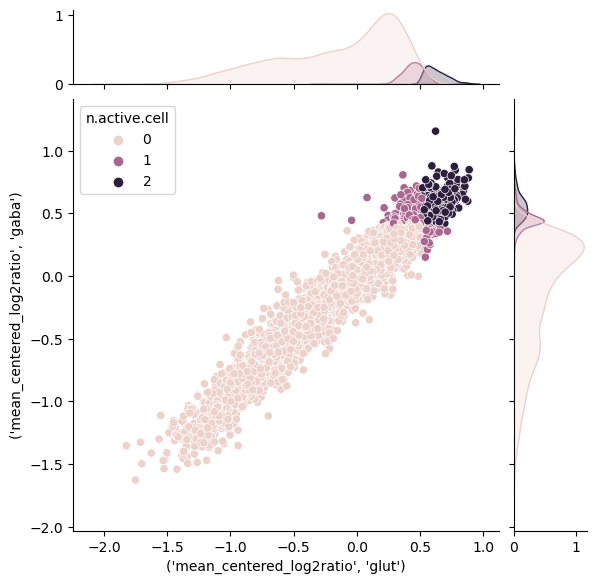

In [119]:
x = ('mean_centered_log2ratio', 'glut')
y = ('mean_centered_log2ratio', 'gaba')
hue ="n.active.cell"
data = joint_activity.loc[joint_activity['strand'] != None]
sns.jointplot(x=x, y=y, data=data, marginal_ticks=True, hue=hue)

## pearson correlation between cell types

In [41]:
stats.pearsonr(data[x], data[y])

PearsonRResult(statistic=0.5920451469027369, pvalue=0.0)

## how many celltype-specific active?

In [54]:
joint_activity.loc[joint_activity['strand'] != None].groupby("n.active.cell")["name"].count()

n.active.cell
0    4468
1     357
2     277
Name: name, dtype: int64

# cell type specific x strand specific 

 2x2 celltype specific coors enriched for strand-specific effects?
 
     - a = n coordinates with cell type AND strand-specific
     - b = n coordinates with cell type NOT strand-specific
     - c = n coordinates NOT cell type specific AND strand-specific
     - d = n coordinates NOT cell type NOT strand-specific
     
        ss +     ss-
    cs +   A.       B
    cs -   C.       D

In [117]:
total_coor = set(joint_strand["coor"])  # get all coordinates
different_coor = {*ss_coor, *cell_coor}  # get set of different coordinates
a = len(cell_coor.intersection(ss_coor))
b = len(cell_coor.difference(ss_coor))
c = len(ss_coor.difference(cell_coor))
d = len(total_coor.difference(different_coor))

a,b,c,d

(283, 59, 180, 1813)

## Do FET

In [115]:
from scipy.stats import fisher_exact

fisher_exact([[a,b],[c,d]])

In [ ]:
strand.loc[strand["name"].str.contains("chr")]